In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from scipy import stats as stat
from scipy import signal
import matplotlib.pyplot as plt
import random
from datetime import datetime as dt
from scipy.stats.distributions import chi2
from scipy import interpolate
from dateutil.rrule import rrule, MONTHLY, YEARLY
from dateutil.rrule import *
from scipy.fftpack import rfft, irfft, fftfreq
from numpy import ma
# from matplotlib.mpl_toolkits.basemap import Basemap as bm
# import xray
from scipy.interpolate import griddata


In [2]:
# List of station names
Stations = ["Brentwood","CalRevelle","CampusView","Colquitz","Colwood","CordovaBay","CrystalView","DeepCove",\
          "Doncaster","EdwardMilne","Esquimalt","FrancesKelsey","FrankHobbs","HappyValley","Helgesen","JamesBay",\
          "JohnMuir","Journey","Keating","Kelset","Lakehill","Lakewood","Lansdowne","Lochside","Macaulay",\
          "MargaretJenkins","Monterey","Parkland","Quadra","Reynolds","Rogers","Sangster","ShawniganSchool",\
          "Shoreline","Sidney","Torquay","UVicSci","Willows","Willway"]

# Read hourly emperature data into a DataFrame
temp_hourly = pd.read_table("AllStations_temperature_h_2019.dat", sep="\s+", names=["time"]+Stations, header=1, index_col=False)

# Adjust the time column by subtracting 366
hourly_time = temp_hourly.time - 366

# Drop the "time" column to keep only temperature columns
temp_hourly = temp_hourly.drop(columns="time")


In [3]:
def interp_nans(alldata):
# Replace NaN values of a dataset with the mean of each column
    newdata = []
    for data in alldata:
        nanmask = np.isnan(data)
        
 
        data[nanmask] = np.nanmean(alldata.T[nanmask], axis=1)
        
        newdata.append(data)
    
    return newdata


In [4]:
def matrix(Frame):
    N = len(Frame.columns)
    Mat = np.zeros((N, len(Frame)))
    remove = []
    
    # Loop through the columns of the DataFrame
    for i in range(N):
        if Frame.columns[i] == "time" or Frame.columns[i] == "Greg":
            # Exclude columns named "time" or "Greg"
            remove.append(i)
        else:
            # Populate the matrix column with the values from the DataFrame column
            Mat[i] = Frame[Frame.columns[i]]
    
    # Remove unwanted columns
    Mat = np.delete(Mat, remove, axis=0)
    
    return Mat


In [5]:
def cubic_interp(data, mins):
    #Performs Cubic spline method to interpulate data in NaN
    remove = np.where(np.isnan(data) == True)
    
    rm_mask = ~np.isnan(data)
    
    cs = CubicSpline(mins[rm_mask], data[rm_mask])
    
    vals = cs(mins[remove])
    
    return vals, remove


In [6]:
def minutedatatime(data):
    #Puts into gregorian
    minutes = np.arange(len(data))/(24*60)
    
    minutes = minutes + 734139.00000 - 366 
    
    data = pd.concat([pd.DataFrame(minutes, columns=["time"]), data], axis=1)
    
    return data

In [7]:
def ticks(start,end, freq):
    #sets ticks for graphs
    years = end[0] - start[0]
    months = end[1]-start[1]+12*years
    print(years)
    print(months)
    Dates = []
    if freq == True:
        ticks = np.zeros(years+1)
        Temp = np.array(list(rrule(YEARLY, dtstart = dt(start[0],start[1],start[2]),until = dt(end[0],end[1],end[2]))))
        for i in range(years+1):
            ticks[i] = dt.toordinal(Temp[i])
            Temp2 = Temp[i].date()
            Dates.append(str(Temp2))
    else:
        ticks = np.zeros(months+1)
        Temp = np.array(list(rrule(MONTHLY, dtstart = dt(start[0],start[1],start[2]), until = dt(end[0],end[1],end[2]))))
        for i in range(months+1):
            ticks[i] = dt.toordinal(Temp[i])
            Temp2 = Temp[i].date()
            Dates.append(str(Temp2))
    return Dates,ticks

In [8]:
#Reading in minutely datasets
jamesbay = pd.read_table("JamesBay_temperature_2019.dat", sep ="\s+", names=["jamesbay"], skiprows=3, index_col=False)
deepcove = pd.read_table("DeepCove_temperature_2019.dat", sep ="\s+", names=["deepcove"], skiprows=3, index_col=False)
discovery = pd.read_table("DiscoveryElementary_temperature_2019.dat", sep ="\s+", names=["discovery"], skiprows=3, index_col=False)
helgesen = pd.read_table("Helgesen_temperature_2019.dat", sep ="\s+", names=["helgesen"], skiprows=3, index_col=False)
johnmuir = pd.read_table("JohnMuir_temperature_2019.dat", sep ="\s+", names=["johnmuir"], skiprows=3, index_col=False)
keating = pd.read_table("Keating_temperature_2019.dat", sep ="\s+", names=["keating"], skiprows=3, index_col=False)
uvic = pd.read_table("UVicSci_temperature_2019.dat", sep ="\s+", names=["uvic"], skiprows=3, index_col=False)
#Converts minute data into a single data file
minutedata = pd.concat([jamesbay,deepcove,discovery,helgesen,johnmuir,keating,uvic], axis=1)
min_ticks = ticks([2010, 1, 1, 0, 0],[2019, 8, 31, 0, 0], freq=True)
Stationsm = ["JamesBay","DeepCove","Discovery","Helgesen","JohnMuir","Keating","UVicSci"]

9
115


In [9]:
# Perform missing data imputation using cubic spline interpolation
matrix_minute_interp = interp_nans(minutedata.to_numpy(na_value=np.nan, copy=True).T)

# Convert the imputed data back to the original format
matrix_minute_array = np.asarray(matrix_minute_interp).T

# Create a DataFrame with the imputed values
minute_df = pd.DataFrame(data=matrix_minute_array.astype(float), columns=Stationsm)

# Add time information to the DataFrame
minute_df = minutedatatime(minute_df)


<ipython-input-3-17dfd5fc4f66>:8: RuntimeWarning: Mean of empty slice
  data[nanmask] = np.nanmean(alldata.T[nanmask], axis=1)


In [10]:
# Iterate through each station's imputed data
min_interlist = []
for stations in matrix_minute_interp:
    # Apply cubic spline interpolation to get values and indices of missing values
    vals, rm = cubic_interp(stations, minute_df.time.to_numpy())
    
    # Replace missing values with interpolated values
    stations[rm] = vals
    
    # Append the updated array to the list
    min_interlist.append(stations)


In [11]:
# Create a DataFrame from the refined imputed data (min_interlist)
minute_df = pd.DataFrame(data=np.asarray(min_interlist).T.astype(float), columns=Stationsm)

# Add time information to the DataFrame
minute_df = minutedatatime(minute_df)

# Add time information to the original minute data DataFrame
minutedata = minutedatatime(minutedata)

# Generate indices for subsetting the data
min_inds = [int(i) for i in np.linspace(0, minutedata.shape[0]-1, 10)]

# Generate indices for all stations
min_allstsn = [int(i) for i in np.arange(0, len(Stationsm), 1)]


In [12]:
# Set the start and end dates for the summer period
startdate = dt.toordinal(dt(2010, 7, 1))
enddate = dt.toordinal(dt(2010, 8, 1))

# Subset the minute_df DataFrame for the summer period
summerdata = minute_df[minute_df.time >= startdate]
summerdata = summerdata[summerdata.time <= enddate]


In [13]:
# Calculate mean, standard deviation, minimum, and maximum values for minute data
meanmin = minute_df.iloc[:, 1:].mean()
stdmin = minute_df.iloc[:, 1:].std()
minval = minute_df.iloc[:, 1:].min()
maxval = minute_df.iloc[:, 1:].max()

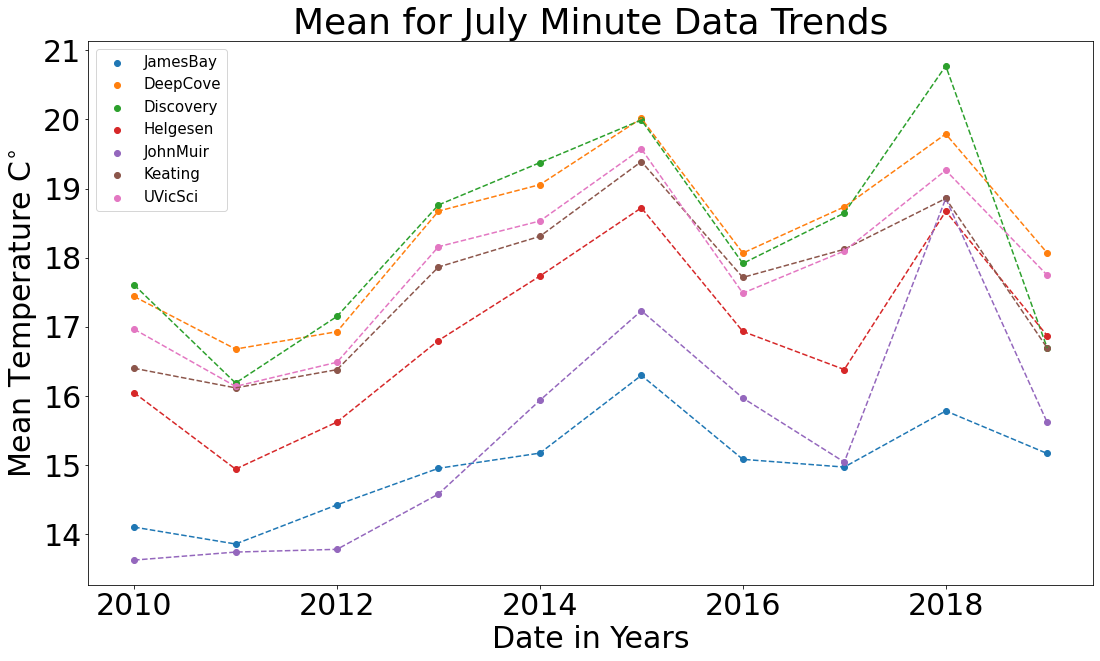

In [14]:
stationlist = []

# Loop through each station
for i in Stationsm:
    yearlist = []

    # Loop through each year from 2010 to 2019
    for k in range(10):
        startdate = dt.toordinal(dt(2010 + k, 7, 1))
        enddate = dt.toordinal(dt(2010 + k, 8, 1))

        # Extract data for the specified station and time range
        summerdata = minute_df[minute_df.time >= startdate]
        summerdata = summerdata[summerdata.time <= enddate]

        # Calculate the mean for the specified station in the given year
        yearlist.append(summerdata[i].mean())

    # Append the list of mean values for each year to the stationlist
    stationlist.append(yearlist)

plt.figure(figsize=(18, 10))
plt.rcParams.update({'font.size': 30})

# Loop through each station
for k in range(7):
    plt.scatter([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], stationlist[k], label=Stationsm[k])
    plt.plot([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], stationlist[k], "--")

plt.ylabel("Mean Temperature C$^{\circ}$")
plt.xlabel("Date in Years")
plt.legend(loc="upper left", fontsize=15)
plt.title("Mean for July Minute Data Trends")
plt.savefig('July.png')


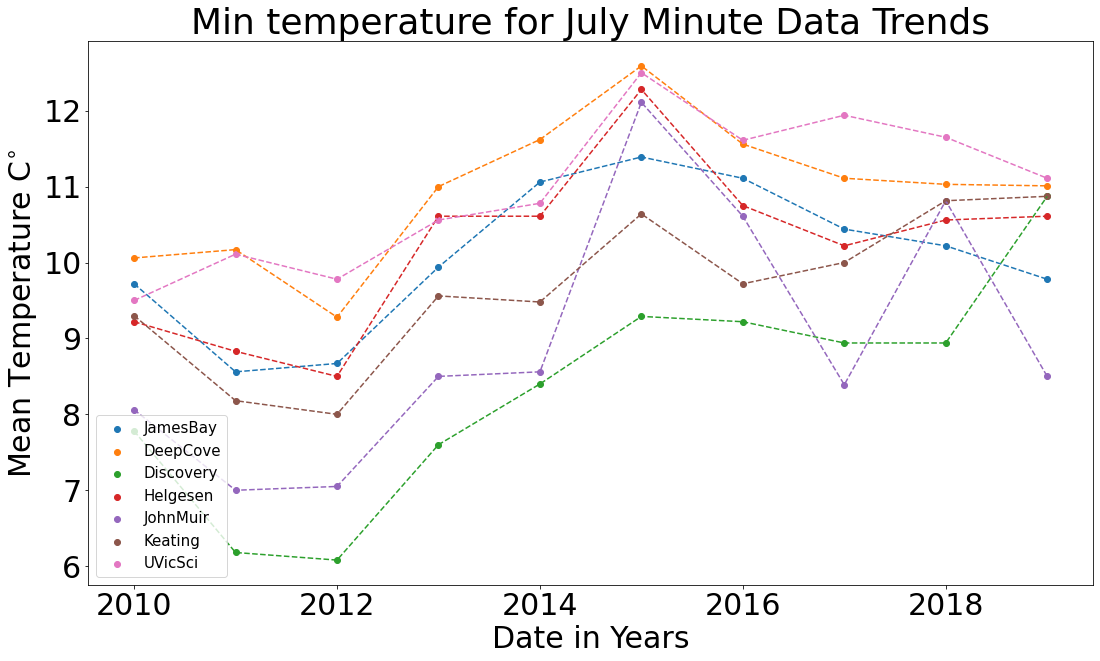

In [15]:
# Initialize an empty list to store minimum temperatures for each station
stationlist = []

# Loop through each station
for i in Stationsm:
    # Initialize an empty list to store minimum temperatures for each year
    yearlist = []
    
    # Loop through each year from 2010 to 2019
    for k in range(10):
        # Define the start and end dates for July of the current year
        startdate = dt.toordinal(dt(2010 + k, 7, 1))
        enddate = dt.toordinal(dt(2010 + k, 8, 1))
        
        # Extract data for the current station and year
        summerdata = minute_df[minute_df.time >= startdate]
        summerdata = summerdata[summerdata.time <= enddate]
        
        # Calculate and append the minimum temperature for the current year
        yearlist.append(summerdata[i].min())
    
    # Append the minimum temperatures for the current station to the main list
    stationlist.append(yearlist)

plt.figure(figsize=(18,10))
plt.rcParams.update({'font.size': 30})

# Loop through each station
for k in range(7):
    plt.scatter([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], stationlist[k], label=Stationsm[k])    
    plt.plot([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], stationlist[k],"--")
    plt.ylabel("Mean Temperature C$^{\circ}$")
    plt.xlabel("Date in Years")
    plt.legend(loc= "lower left", fontsize = 15)
plt.title("Min temperature for July Minute Data Trends")
plt.savefig('min.png')

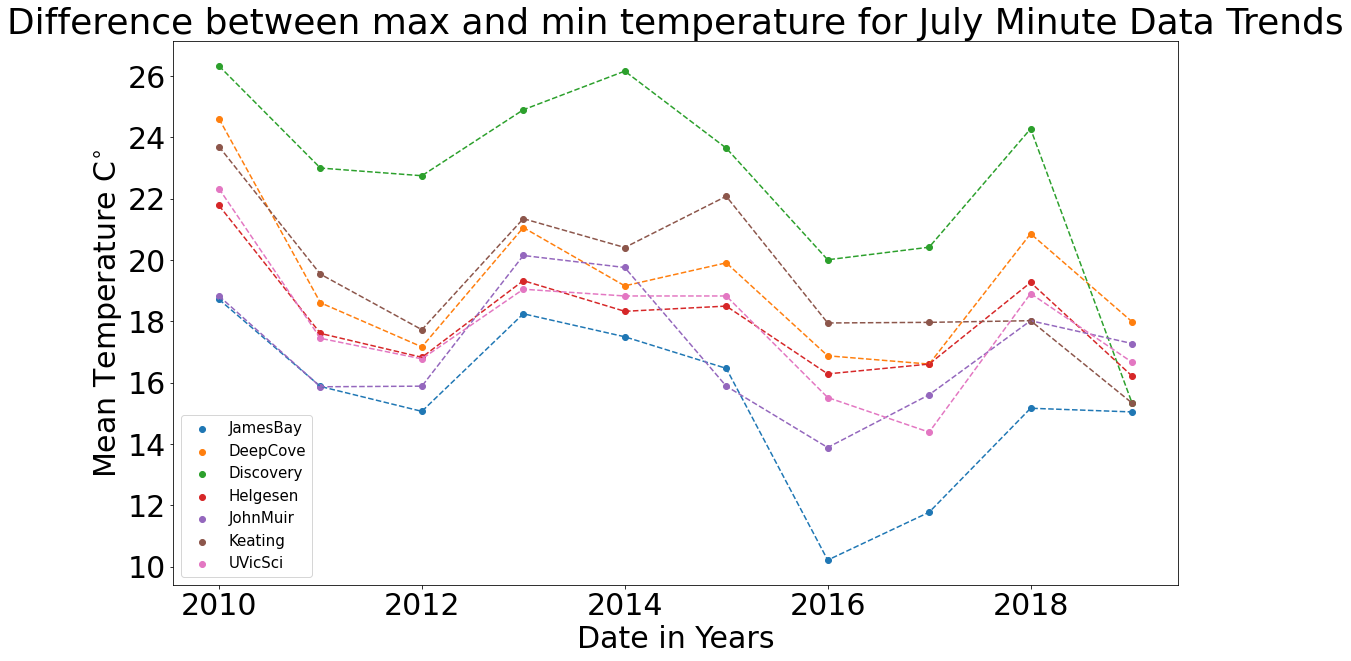

In [16]:
# Initialize an empty list to store temperature differences for each station
stationlistdiff = []

# Loop through each station
for i in Stationsm:
    # Initialize an empty list to store temperature differences for each year
    yearlistdiff = []
    
    # Loop through each year from 2010 to 2019
    for k in range(10):
        # Define the start and end dates for July of the current year
        startdate = dt.toordinal(dt(2010 + k, 7, 1))
        enddate = dt.toordinal(dt(2010 + k, 8, 1))
        
        # Extract data for the current station and year
        summerdata = minute_df[minute_df.time >= startdate]
        summerdata = summerdata[summerdata.time <= enddate]
        
        # Calculate and append the temperature difference (max - min) for the current year
        yearlistdiff.append(summerdata[i].max() - summerdata[i].min())
    
    # Append the temperature differences for the current station to the main list
    stationlistdiff.append(yearlistdiff)

plt.figure(figsize=(18,10))
plt.rcParams.update({'font.size': 30})

for k in range(7):
    plt.scatter([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], stationlistdiff[k], label=Stationsm[k])    
    plt.plot([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], stationlistdiff[k],"--")
    plt.ylabel("Mean Temperature C$^{\circ}$")
    plt.xlabel("Date in Years")
    plt.legend(loc= "lower left", fontsize = 15)
plt.title("Difference between max and min temperature for July Minute Data Trends")
plt.savefig('Difference.png')

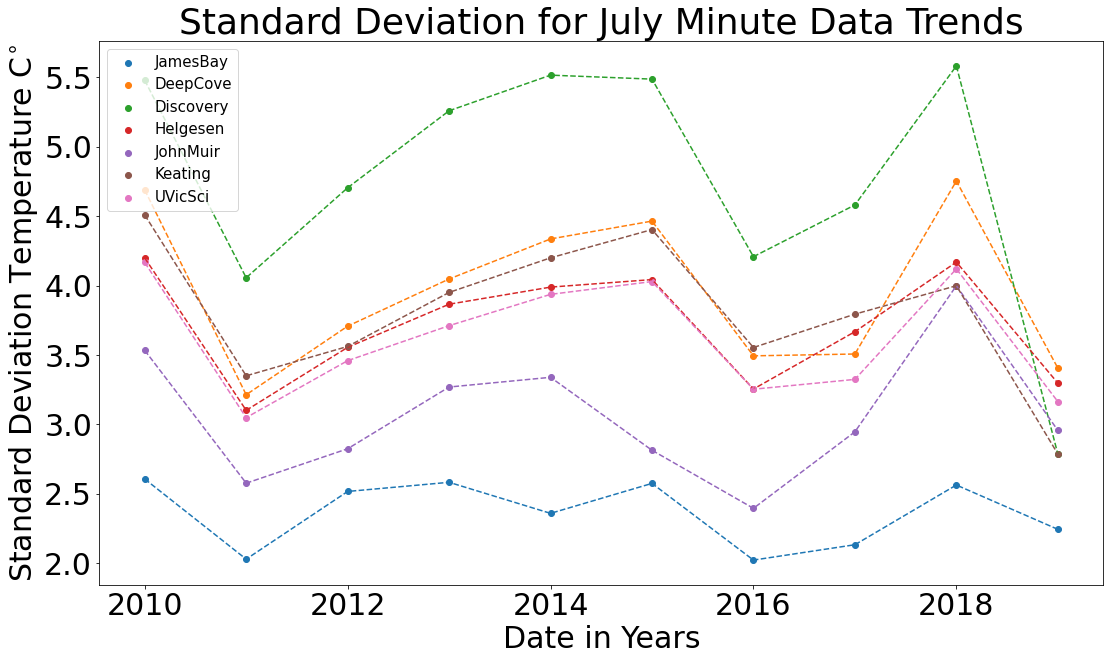

In [17]:
# Initialize an empty list to store standard deviations of temperatures for each station
stationlist = []

# Loop through each station
for i in Stationsm:
    # Initialize an empty list to store standard deviations for each year
    yearlist = []
    
    # Loop through each year from 2010 to 2019
    for k in range(10):
        # Define the start and end dates for July of the current year
        startdate = dt.toordinal(dt(2010 + k, 7, 1))
        enddate = dt.toordinal(dt(2010 + k, 8, 1))
        
        # Extract data for the current station and year
        summerdata = minute_df[minute_df.time >= startdate]
        summerdata = summerdata[summerdata.time <= enddate]
        
        # Calculate and append the standard deviation of temperatures for the current year
        yearlist.append(summerdata[i].std())
    
    # Append the standard deviations for the current station to the main list
    stationlist.append(yearlist)

plt.figure(figsize=(18,10))
plt.rcParams.update({'font.size': 30})

for k in range(7):
    plt.scatter([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], stationlist[k], label=Stationsm[k])    
    plt.plot([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], stationlist[k],"--")
    plt.ylabel("Standard Deviation Temperature C$^{\circ}$")
    plt.xlabel("Date in Years")
    plt.legend(loc= "upper left", fontsize = 15)
plt.title("Standard Deviation for July Minute Data Trends")
plt.savefig('Julystd.png')

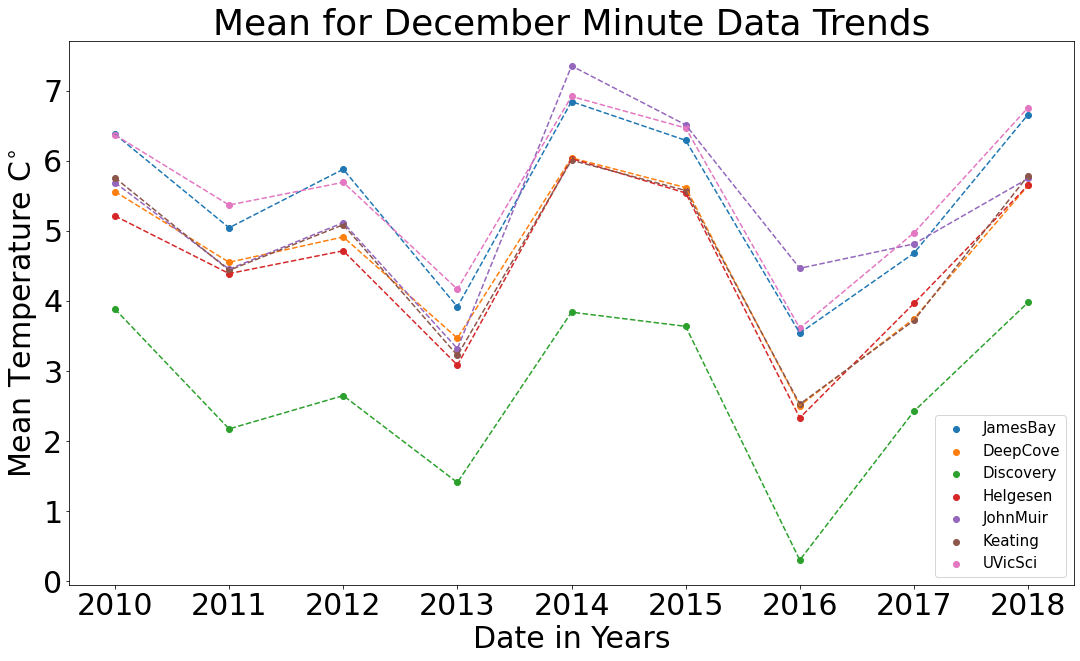

In [18]:
# Initialize an empty list to store the yearly data for each station
stationlist = []

# Iterate over each station
for i in Stationsm:
    # Initialize an empty list to store the mean winter temperature for each year
    yearlist = []
    
    # Iterate over 10 years from 2010 to 2019
    for k in range(10):
        # Define the start and end dates for December of each year
        startdate = dt.toordinal(dt(2010 + k, 12, 1))
        enddate = dt.toordinal(dt(2010 + k, 12, 31))
        
        # Extract the winter data for the current station and year
        winterdata = minute_df[minute_df.time >= startdate]
        winterdata = winterdata[winterdata.time <= enddate]
        
        # Calculate and append the mean winter temperature for the current year
        yearlist.append(winterdata[i].mean())
    
    # Append the yearly data for the current station to the main list
    stationlist.append(yearlist)

plt.figure(figsize=(18,10))
plt.rcParams.update({'font.size': 30})

for k in range(7):
    plt.scatter([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], stationlist[k], label=Stationsm[k])    
    plt.plot([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], stationlist[k],"--")
    plt.ylabel("Mean Temperature C$^{\circ}$")
    plt.xlabel("Date in Years")
    plt.legend(loc= "lower right", fontsize = 15)

plt.title("Mean for December Minute Data Trends")
plt.savefig('Decemeber.png')

In [19]:
Corrs = minute_df.drop(columns="time").corr()
Corrs

,JamesBay,DeepCove,Discovery,Helgesen,JohnMuir,Keating,UVicSci
JamesBay,1.000000,0.950210,0.937805,0.949254,0.947007,0.954720,0.949260
DeepCove,0.950210,1.000000,0.978816,0.968024,0.932503,0.986559,0.978171
Discovery,0.937805,0.978816,1.000000,0.960932,0.931620,0.976980,0.958942
Helgesen,0.949254,0.968024,0.960932,1.000000,0.946257,0.969329,0.974460
JohnMuir,0.947007,0.932503,0.931620,0.946257,1.000000,0.938868,0.925650
Keating,0.954720,0.986559,0.976980,0.969329,0.938868,1.000000,0.975617
UVicSci,0.949260,0.978171,0.958942,0.974460,0.925650,0.975617,1.000000


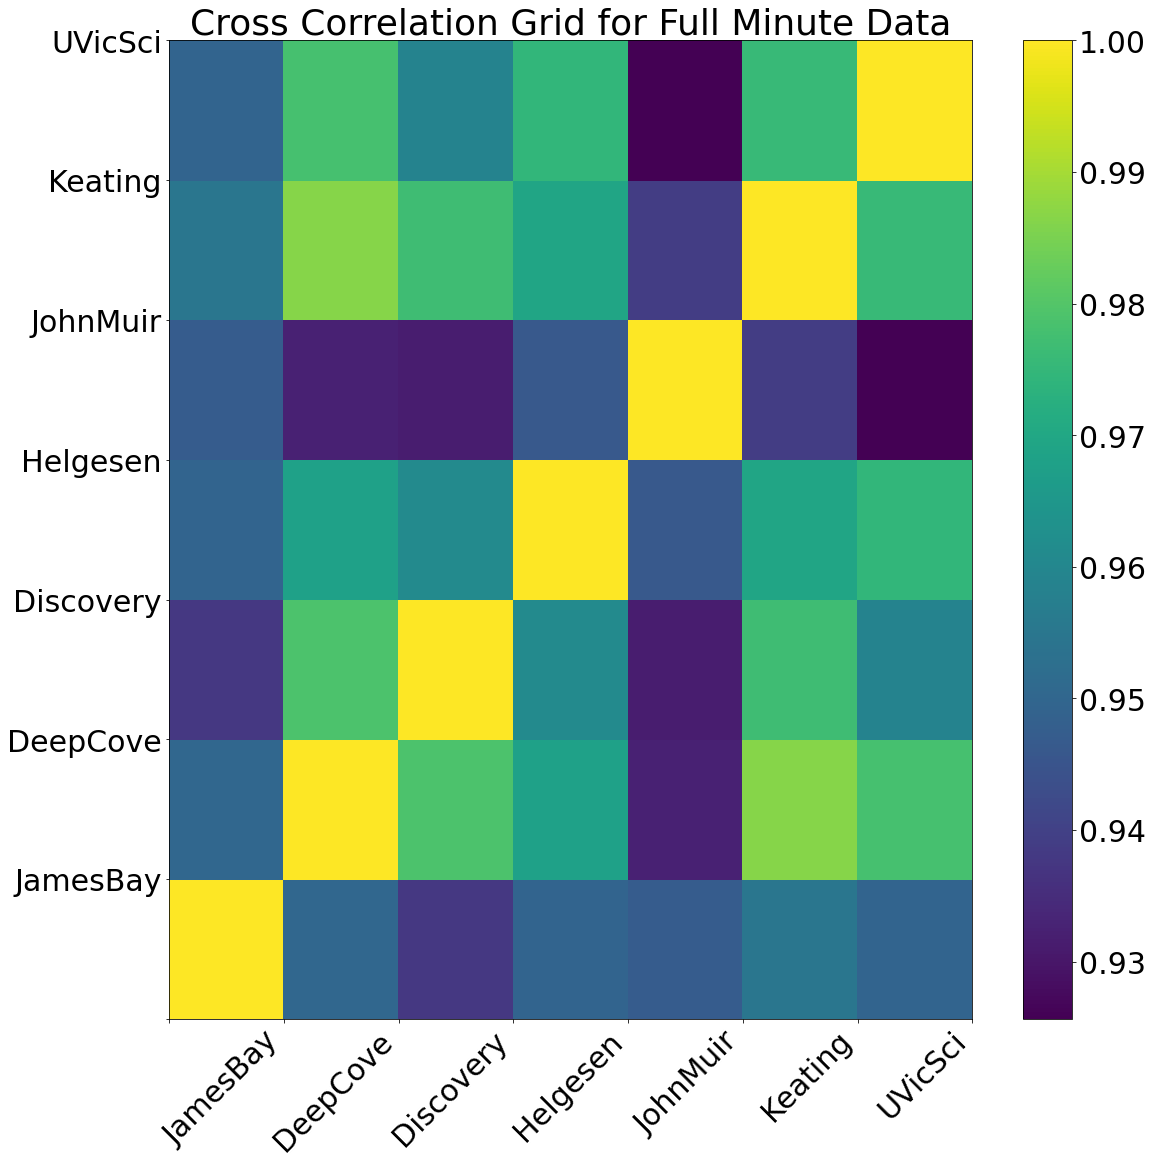

In [20]:
plt.figure(figsize = (18,18))
plt.title("Cross Correlation Grid for Full Minute Data")
plt.pcolormesh(minute_df.rename(columns={'time': ''}, index={'time': ''}).columns, minute_df.rename(columns={'time': ''}, index={'time': ''}).columns,Corrs)
plt.colorbar()
plt.rcParams.update({'font.size': 8})
plt.xticks(rotation=45, ha="right")
plt.savefig("Cross.png")

In [21]:
def fx(x,mu,sigma):
    #Probability density formula PDF
    fx = np.exp(-1/2 * ((x-mu)/sigma)**2) / (sigma * np.sqrt(2 * np.pi ))
    return fx

In [22]:
linspacearray = []

# Iterate over the range of the number of stations (assuming maxval and minval have the same length)
for k in range(len(maxval)):
    # Generate an array of 1000 evenly spaced values between the floor of the minimum and the integer value of the maximum
    linspacearray.append(np.linspace(np.floor(minval[k]), int(maxval[k]), 1000))

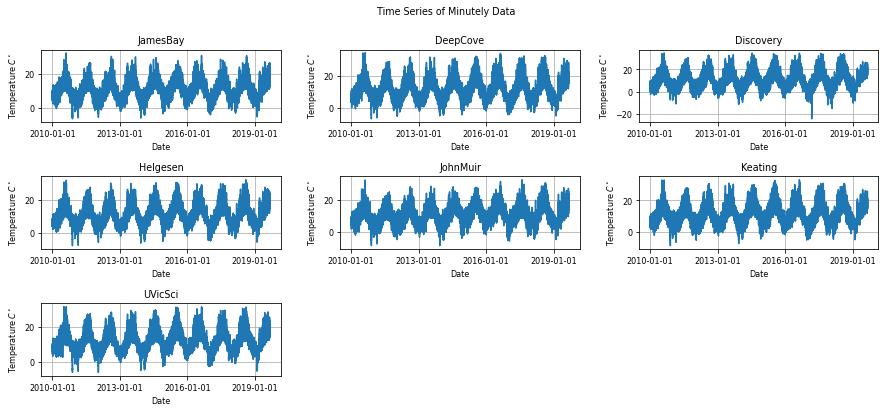

In [23]:
fig, axs = plt.subplots(3,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .75, wspace=.25)
plt.suptitle("Time Series of Minutely Data")



axs = axs.ravel()
i=0
for k in Stationsm:
    axs[i].title.set_text(k)
    axs[i].plot(minute_df.time, minute_df[k])
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel(r"Temperature $C^{\circ}$")
    axs[i].set_title(k)
    axs[i].set_xticks(min_ticks[1][::3])
    axs[i].set_xticklabels(min_ticks[0][::3])
    axs[i].grid()
    i+=1
fig.delaxes(axs[i])
fig.delaxes(axs[i+1])
plt.rcParams.update({'font.size': 8})
plt.savefig('Time Series of Minutely Data.png')

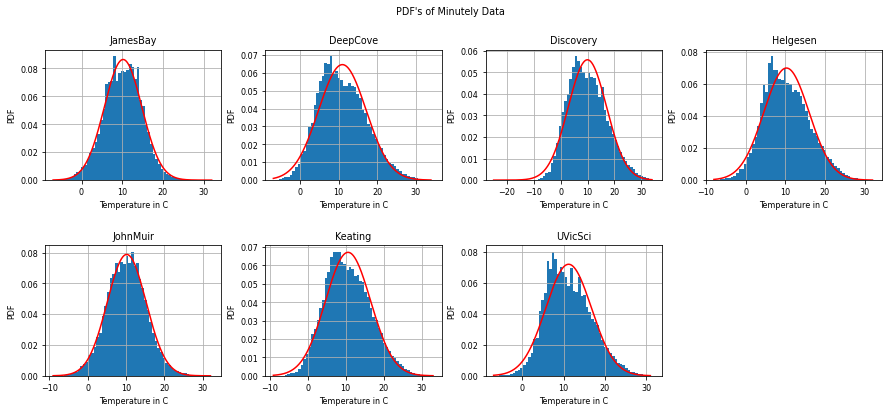

In [24]:
fig, axs = plt.subplots(2,4, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.25)
plt.suptitle("PDF's of Minutely Data")

axs = axs.ravel()
k=0
for stations in Stationsm:
    fx_min = fx(linspacearray[k], meanmin[k], stdmin[k])
    axs[k].plot(linspacearray[k], fx_min, "r")
    axs[k].title.set_text(stations)
    axs[k].hist(minute_df[stations],bins=60,density=True)
    axs[k].set_xlabel("Temperature in C")
    axs[k].set_ylabel("PDF")
    axs[k].grid()
    k+=1
fig.delaxes(axs[k])
plt.savefig('PDF of Minutely Data.png')

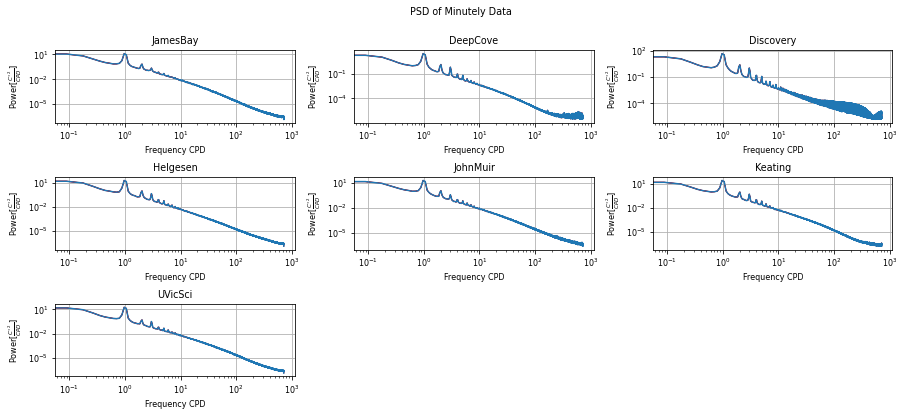

In [25]:
nperseg = 2**14
fs = 1440

fig, axs = plt.subplots(3,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .75, wspace=.25)
plt.suptitle("PSD of Minutely Data")
axs = axs.ravel()
i=0
a = 0.05
df = nperseg*4/3
upper  = df /chi2.ppf(a/2,df)
lower  = df /chi2.ppf(1-a/2,df)

for k in Stationsm:
    freq, power= signal.welch(minute_df[k], nperseg = nperseg, fs = fs)
    axs[i].title.set_text(k)
    axs[i].plot(freq, power)
    axs[i].fill_between(freq, upper*power, lower*power,color =  "r")
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].set_xlabel("Frequency CPD")
    axs[i].set_ylabel(r"Power[$\frac{C^{\circ 2}}{CPD}$]")
    axs[i].grid()
    i+=1
fig.delaxes(axs[i])    
fig.delaxes(axs[i+1])
plt.savefig('PSD of Minutely Data.png')

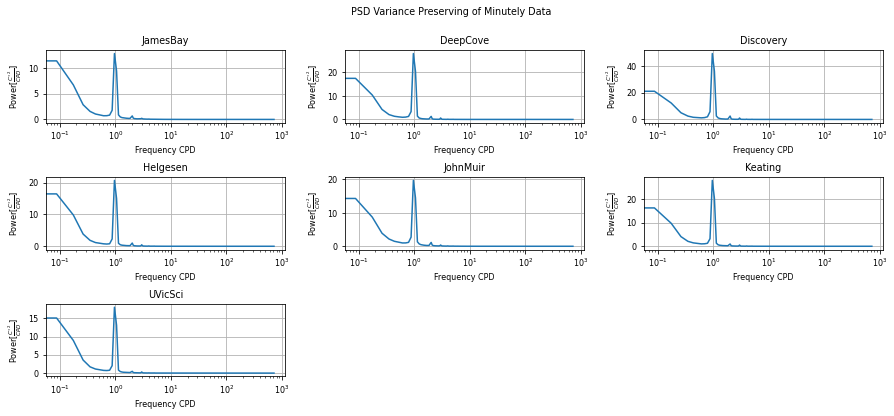

In [26]:

fig, axs = plt.subplots(3,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .75, wspace=.25)
plt.suptitle("PSD Variance Preserving of Minutely Data")
axs = axs.ravel()
i=0
for k in Stationsm:
    freq, power= signal.welch(minute_df[k], nperseg = nperseg, fs = fs)
    axs[i].title.set_text(k)
    axs[i].semilogx(freq, power)
    axs[i].set_xlabel("Frequency CPD")
    axs[i].set_ylabel(r"Power[$\frac{C^{\circ 2}}{CPD}$]")
    axs[i].grid()
    i+=1
fig.delaxes(axs[i])    
fig.delaxes(axs[i+1])
plt.savefig('PSD Variance Preserving of Minutely Data.png')

9
115


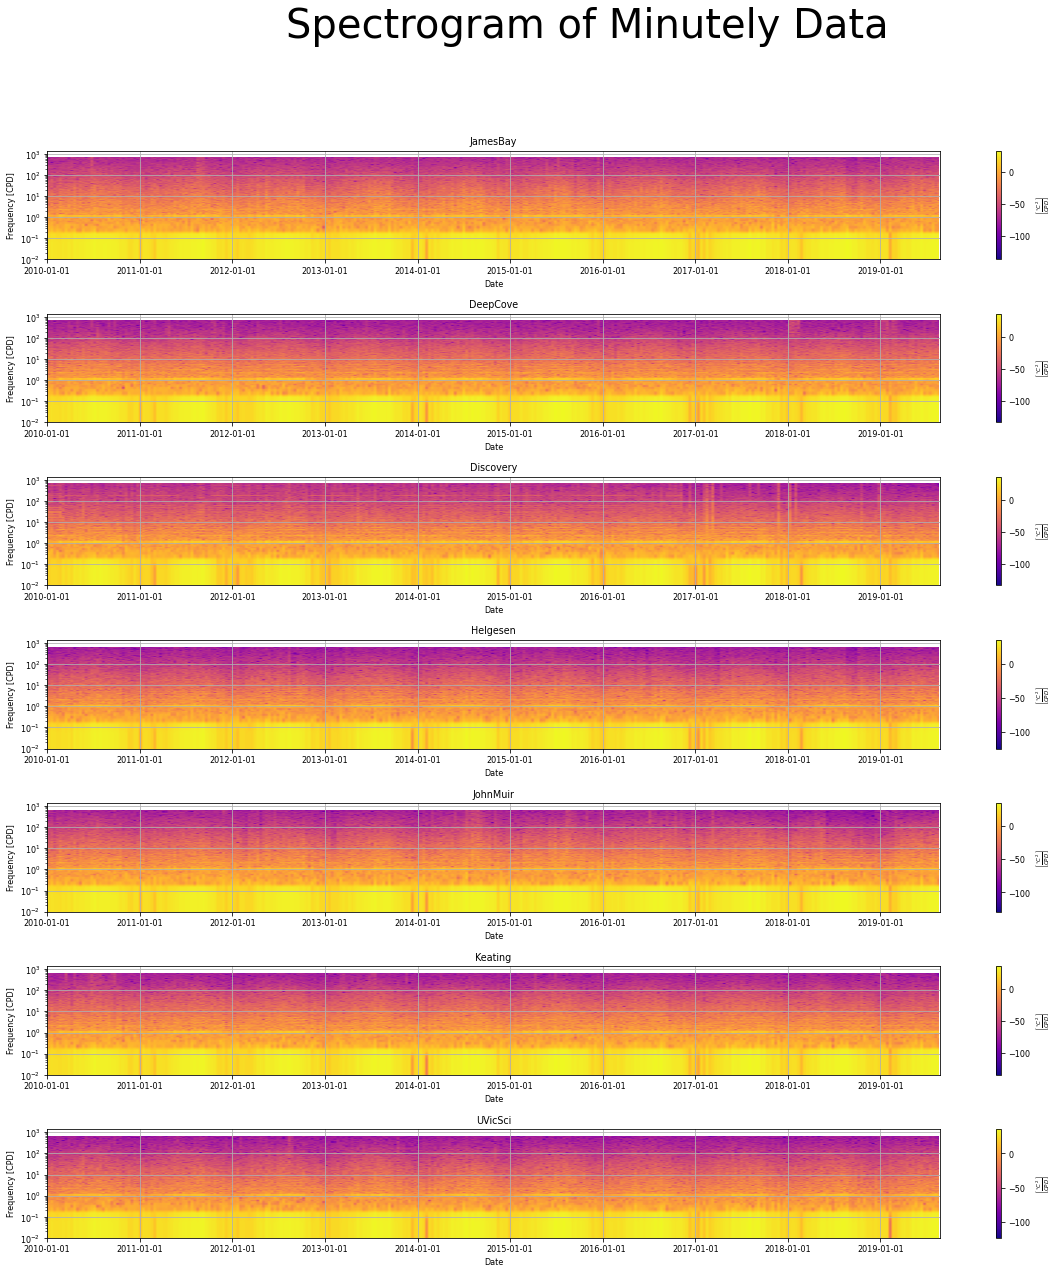

In [27]:
min_ticks = ticks([2010, 1, 1, 0, 0],[2019, 8, 31, 0, 0], freq=True)

fig, axs = plt.subplots(7,1, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
plt.suptitle("Spectrogram of Minutely Data", size = 40)


axs = axs.ravel()
i=0
for k in Stationsm:
    values1, ybins1, xbins1, im1 = axs[i].specgram(minute_df[k],NFFT = 2**14,Fs = fs,cmap = "plasma")
    axs[i].title.set_text(k)
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Frequency [CPD]")
    axs[i].set_yscale("log")
    axs[i].set_ylim(1e-2,fs)
    axs[i].set_title(k)
    axs[i].set_xticks(min_ticks[1]-(minute_df.time[0]))
    axs[i].set_xticklabels(min_ticks[0])
    axs[i].grid()
    fig.colorbar(im1, ax=axs[i],label = r"$\left[\frac{{}^{\circ}C^2}{CPD}\right]$")
    i+=1
plt.savefig('Spectrogram of minutely data.png')


In [28]:
minutedata = minutedata.set_index("time")
minute_df = minute_df.set_index("time")

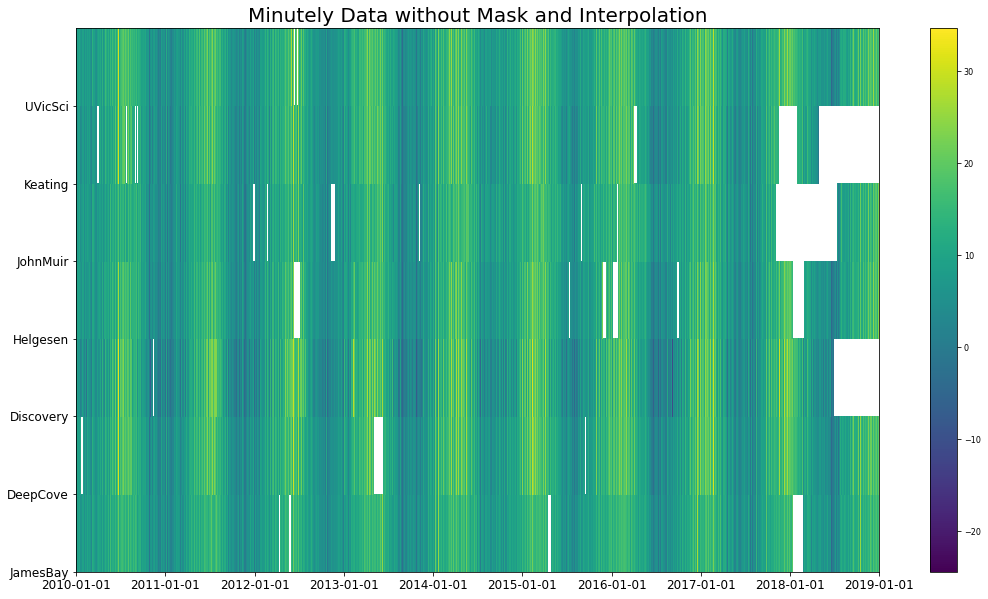

In [29]:
f = plt.figure(figsize=(18,10))
plt.pcolormesh(minutedata.to_numpy(na_value=np.nan, copy=True).T)
plt.xticks(min_inds,min_ticks[0], size=12)
plt.yticks(min_allstsn, Stationsm, size = 12)
plt.colorbar()
plt.title("Minutely Data without Mask and Interpolation", fontsize = 20)
plt.savefig('Minutely Data without Mask and Interpolation.png')

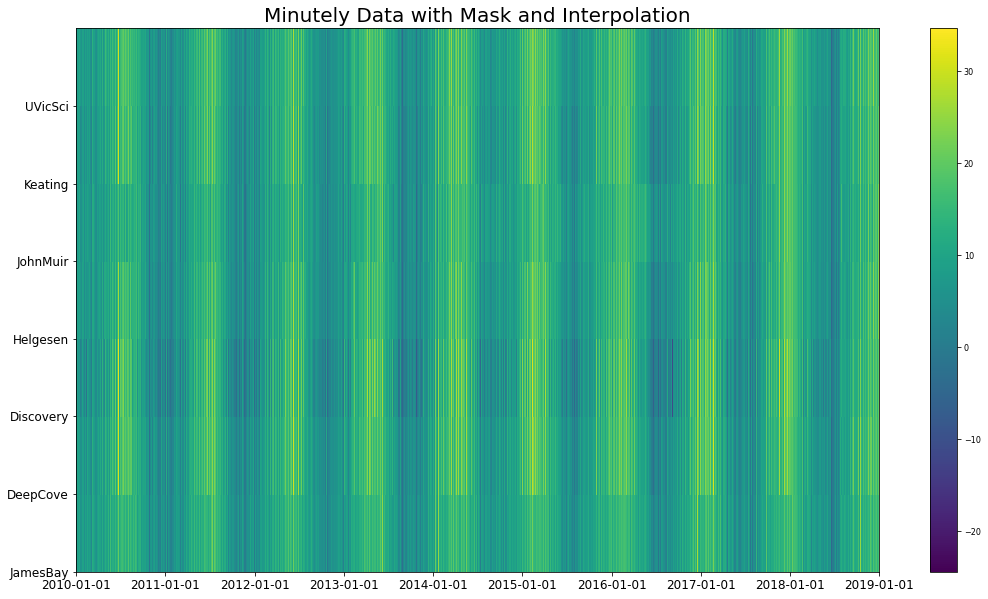

In [30]:
f = plt.figure(figsize=(18,10))
plt.pcolormesh(minute_df.to_numpy(na_value=np.nan, copy=True).T)
plt.xticks(min_inds,min_ticks[0], size=12)
plt.yticks(min_allstsn, Stationsm, size = 12)
plt.colorbar()
plt.title("Minutely Data with Mask and Interpolation", fontsize = 20)
plt.savefig('Minutely Data with Mask and Interpolation.png')

In [31]:
# Interpolate NaN values in the hourly temperature data using cubic interpolation
matrix_hourly_interp = interp_nans(temp_hourly.to_numpy(na_value=np.nan, copy=True).T)

# Initialize an empty list to store arrays with interpolated values
interlist = []

# Iterate over each station in the interpolated matrix
for stations in matrix_hourly_interp:
    # Perform cubic interpolation for NaN values and update the station data
    vals, rm = cubic_interp(stations, hourly_time.to_numpy())
    stations[rm] = vals
    interlist.append(stations)

# Check if there are still NaN values in the original hourly temperature data after interpolation
nan_check = np.isnan(temp_hourly.to_numpy(na_value=np.nan, copy=True).T).any()


<ipython-input-3-17dfd5fc4f66>:8: RuntimeWarning: Mean of empty slice
  data[nanmask] = np.nanmean(alldata.T[nanmask], axis=1)


In [32]:
# Create a DataFrame from the list of interpolated hourly temperature data
hourly_df = pd.DataFrame(data=np.asarray(interlist).T.astype(float), columns=Stations)

# Concatenate the hourly time column to the DataFrame
hourly_df = pd.concat([hourly_df, pd.DataFrame(hourly_time, columns=["time"])], axis=1)

# List of stations to be dropped from the DataFrame
dropstations = ["Willows", "UVicSci", "ShawniganSchool", "Kelset", "Monterey", "Quadra"]

# Drop specified stations from the DataFrame
hourly_df = hourly_df.drop(columns=dropstations)

# Concatenate the hourly time column to the original temperature DataFrame
temp_hourly = pd.concat([hourly_time, temp_hourly], axis=1)

# Generate indices for plotting ticks
inds = [int(i) for i in np.linspace(0, temp_hourly.shape[0] - 1, 12)]
allstsn = [int(i) for i in np.arange(0, len(Stations), 1)]

# Generate ticks for hourly data
hour_ticks = ticks([2008, 1, 1, 0, 0], [2019, 8, 31, 0, 0], freq=True)

11
139


In [33]:
temp_hourly = temp_hourly.set_index("time")
hourly_df = hourly_df.set_index("time")


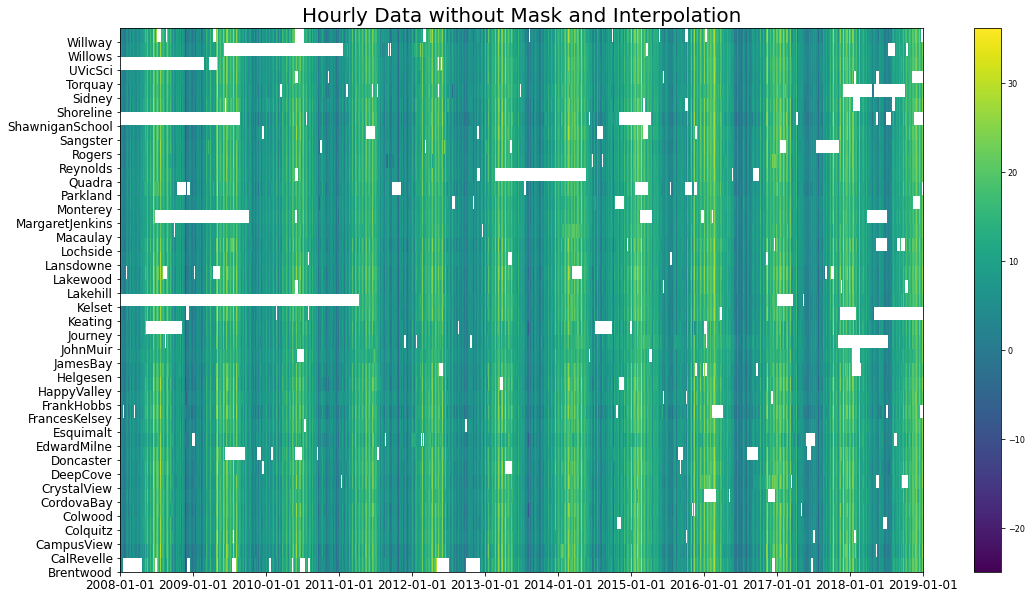

In [34]:
f = plt.figure(figsize=(18,10))
plt.pcolormesh(temp_hourly.to_numpy(na_value=np.nan, copy=True).T)
plt.xticks(inds,hour_ticks[0], size=12)
plt.yticks(allstsn, Stations, size = 12)
plt.colorbar()
plt.title("Hourly Data without Mask and Interpolation", fontsize = 20)
plt.savefig('Hourly Data without Mask and Interpolation.png')


<ipython-input-35-e370467967bb>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(hourly_df.index, hourly_df.columns, hourly_df.to_numpy(na_value=np.nan, copy=True).T)


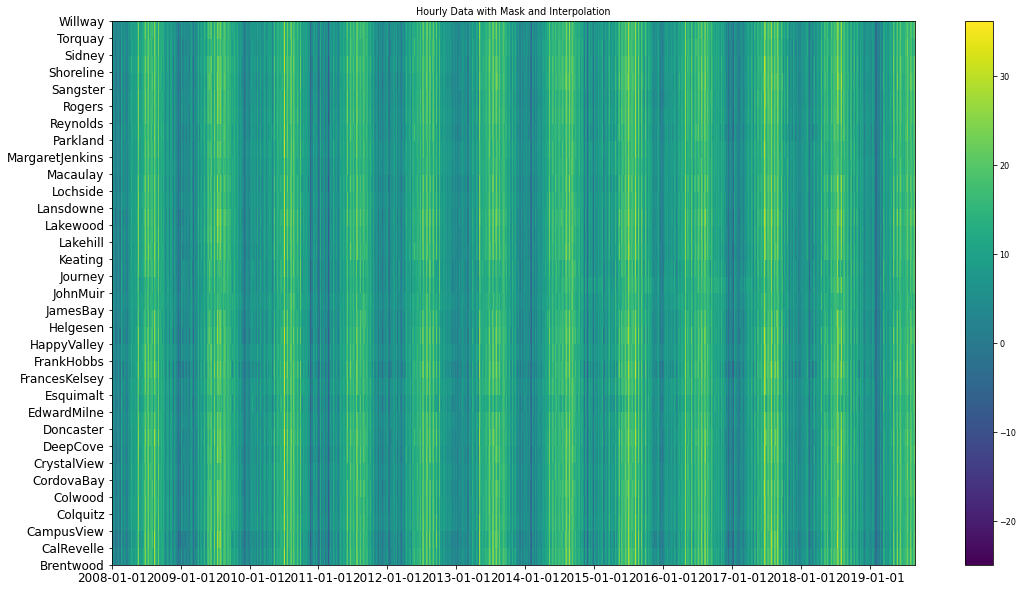

In [35]:
f = plt.figure(figsize=(18,10))
plt.pcolormesh(hourly_df.index, hourly_df.columns, hourly_df.to_numpy(na_value=np.nan, copy=True).T)
plt.xticks(hour_ticks[1][hour_ticks[1]!=0],hour_ticks[0], size = 12)
plt.yticks(size = 12)
plt.colorbar()
plt.title("Hourly Data with Mask and Interpolation")
plt.savefig('Hourly Data with Mask or Interpolation.png')